In [7]:
import pandas as pd
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, multilabel_confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
from tqdm import tqdm
from dataset import ChestXRayDataset
from CNN import create_model
from torch.amp import autocast  # Import autocast if needed
%matplotlib inline

Using device: cuda
Validation DataLoader is ready


/tmp/ipykernel_81434/3066181312.py:70: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


Model loaded and set to evaluation mode


Generating Predictions: 100%|██████████| 354/354 [01:28<00:00,  4.01it/s]
/tmp/ipykernel_81434/3066181312.py:100: RuntimeWarning: overflow encountered in exp
  all_probs = 1 / (1 + np.exp(-all_preds))


Predictions generated.
=== Overall Evaluation Metrics ===
Accuracy: 0.4793
Precision (Macro): 0.3542
Recall (Macro): 0.2085
F1-Score (Macro): 0.2233
Precision (Micro): 0.5504
Recall (Micro): 0.5106
F1-Score (Micro): 0.5298

Classification Report
                    precision    recall  f1-score   support

        No Finding       0.61      0.91      0.73     12076
       Atelectasis       0.41      0.16      0.23      2364
      Cardiomegaly       0.42      0.14      0.20       548
          Effusion       0.45      0.41      0.43      2701
      Infiltration       0.42      0.30      0.35      4048
              Mass       0.45      0.05      0.10      1222
            Nodule       0.44      0.05      0.08      1270
         Pneumonia       0.00      0.00      0.00       275
      Pneumothorax       0.40      0.35      0.38      1165
     Consolidation       0.00      0.00      0.00       918
             Edema       0.50      0.01      0.02       419
         Emphysema       0.49    

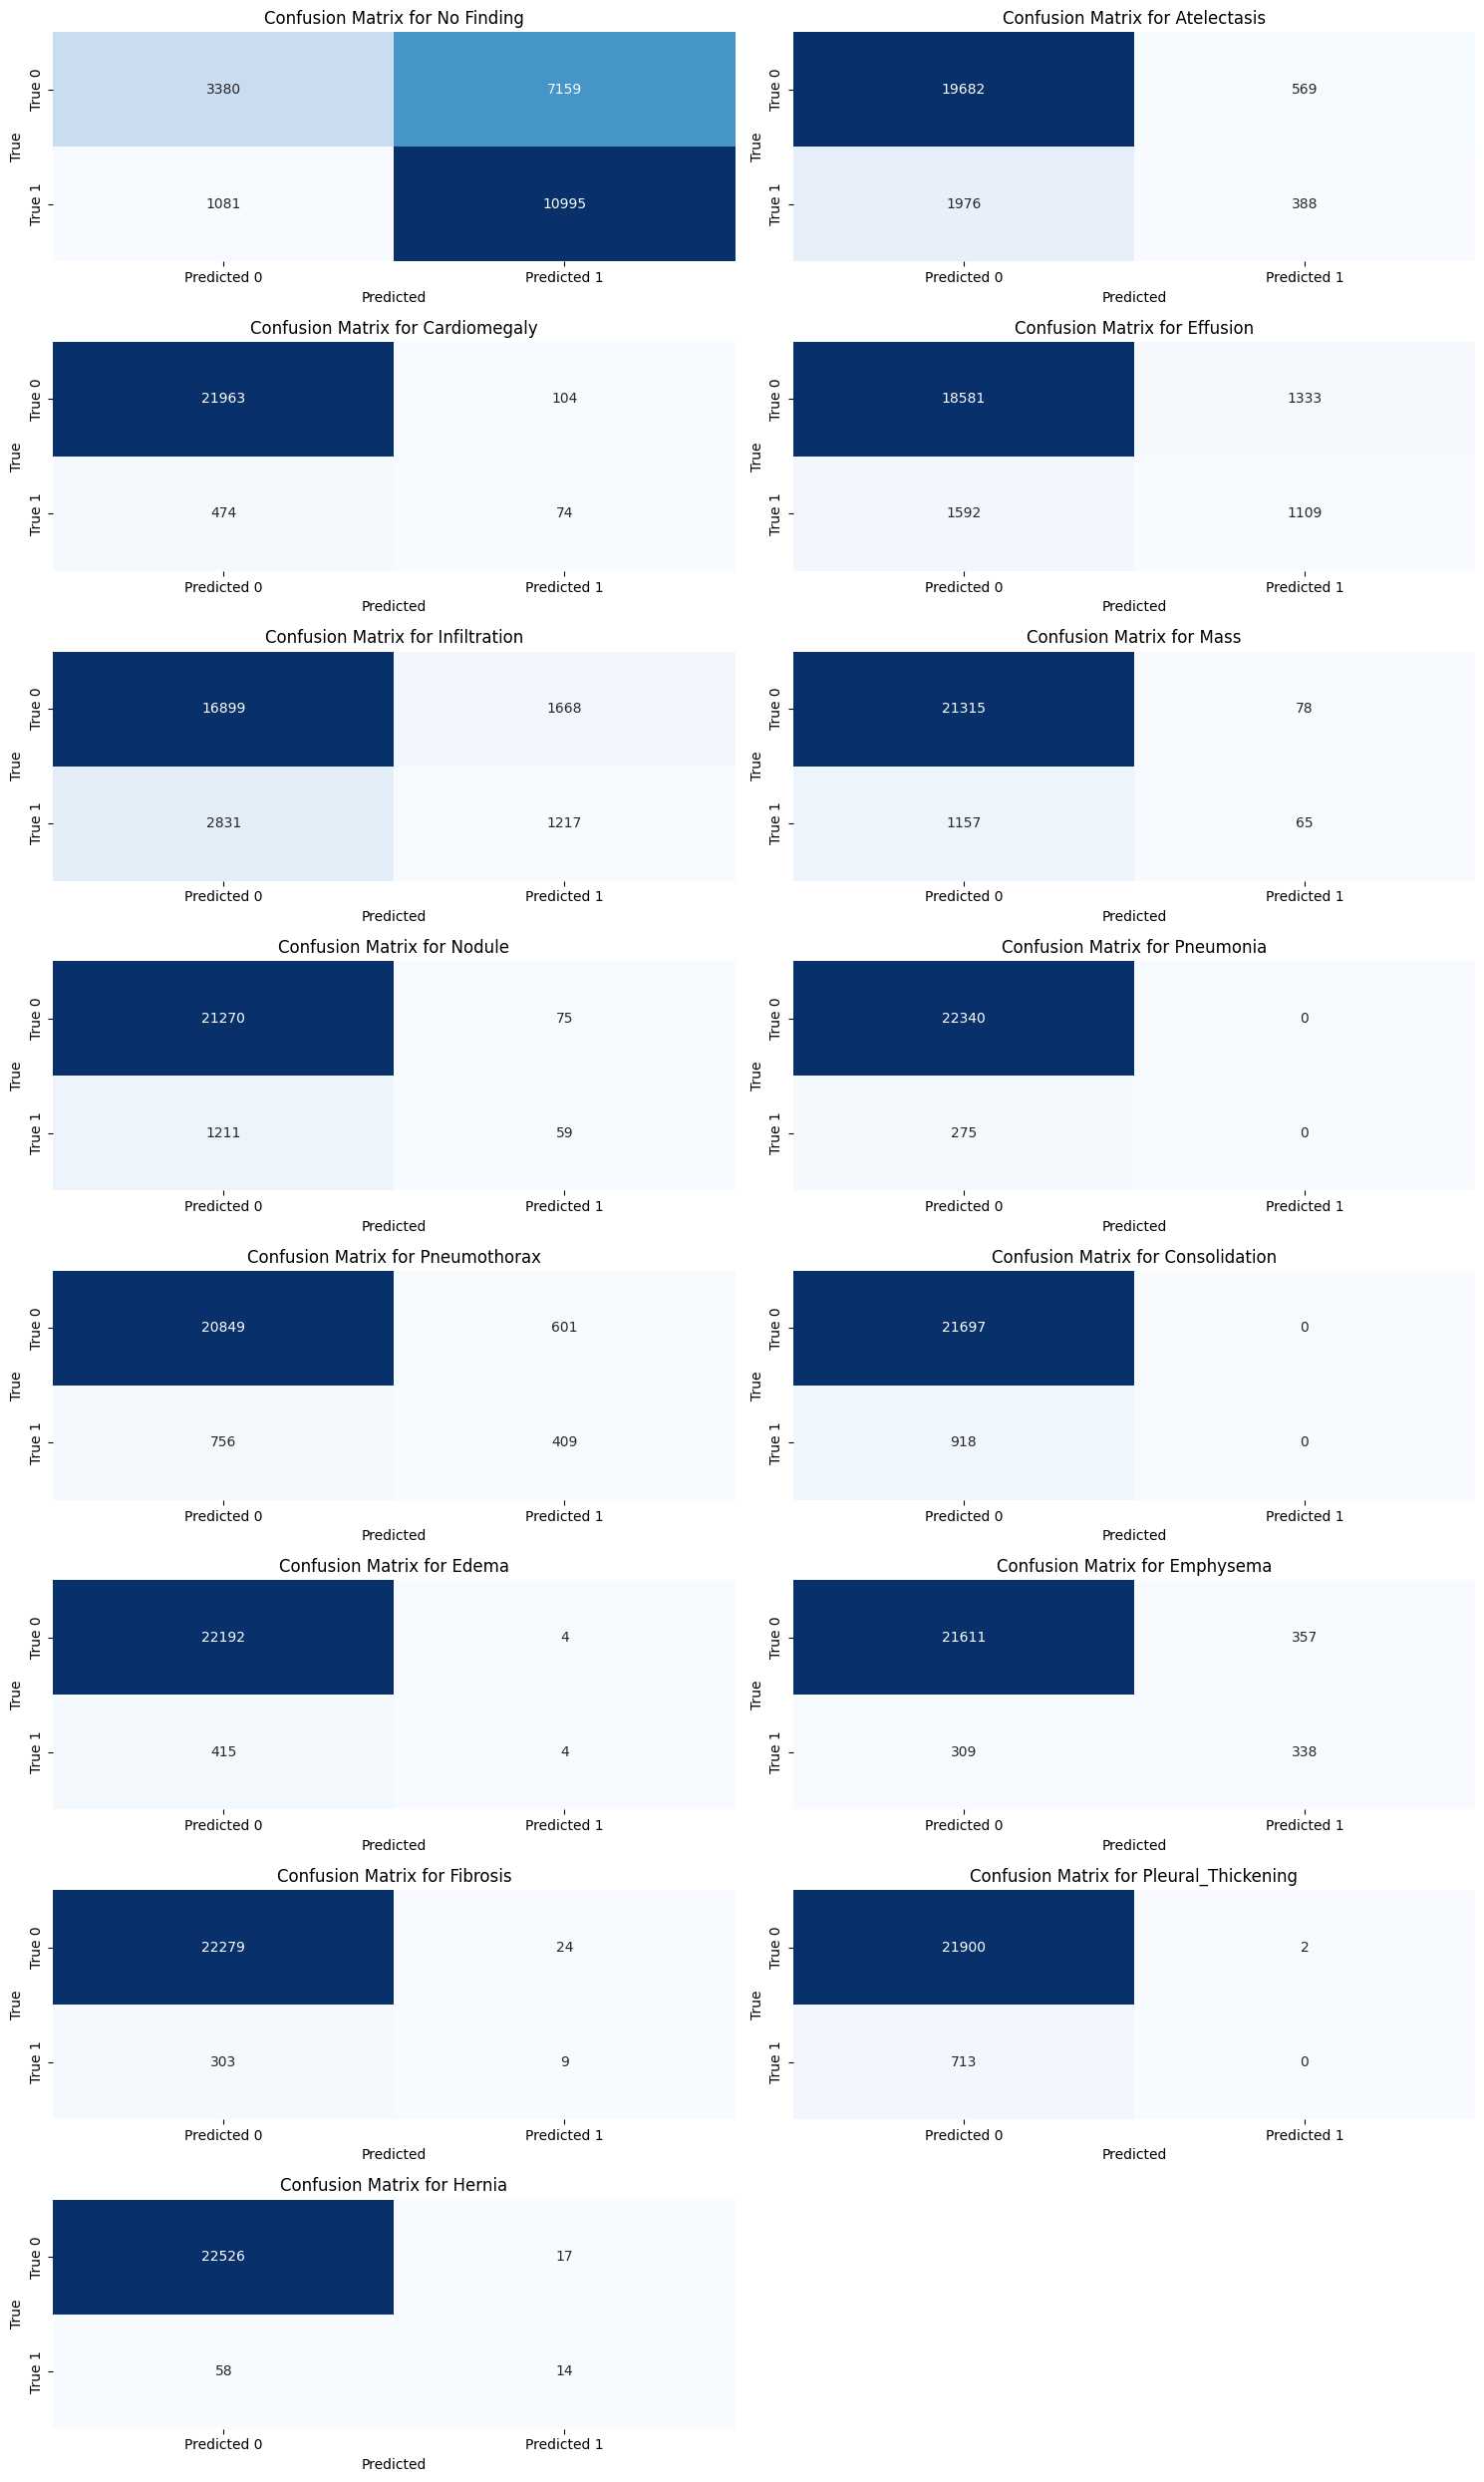

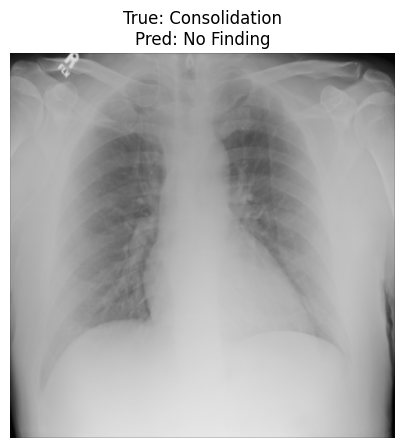

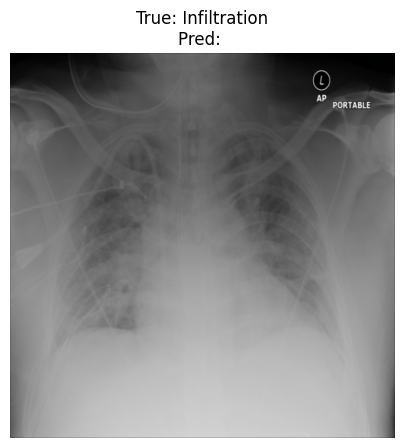

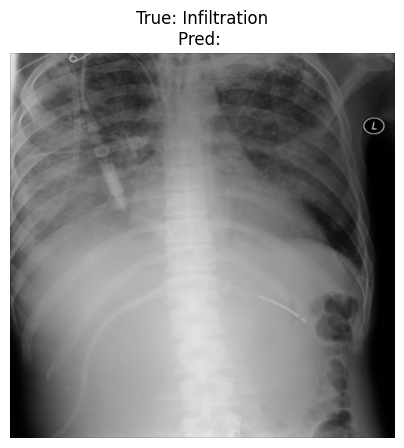

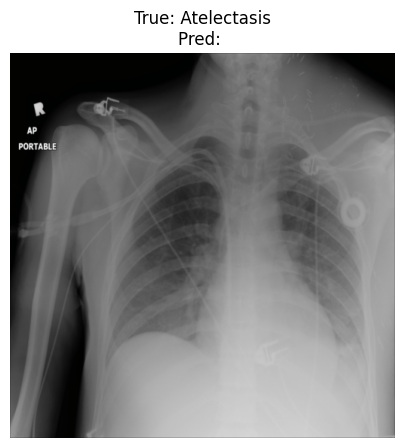

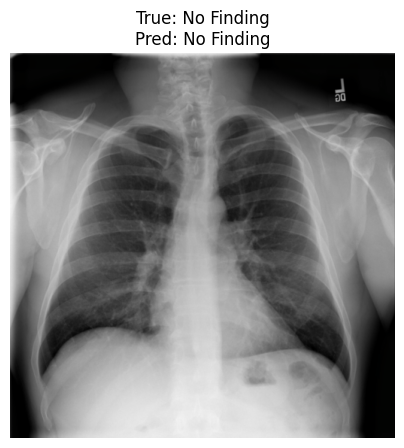

In [9]:

classes = [
    "No Finding", "Atelectasis", "Cardiomegaly", "Effusion", "Infiltration",
    "Mass", "Nodule", "Pneumonia", "Pneumothorax",
    "Consolidation", "Edema", "Emphysema", "Fibrosis",
    "Pleural_Thickening", "Hernia"
]

NUM_CLASSES = 15
IMAGE_SIZE = 512
BATCH_SIZE = 64

# Device configuration
device = torch.device('cuda')
print(f'Using device: {device}')

# Load the MultiLabelBinarizer fitted during training
# It's recommended to save the fitted mlb during training and load it here
# For demonstration, we'll assume the same classes and order
mlb = MultiLabelBinarizer(classes=classes)

# Load and preprocess the data
DATA_CSV = "Data/Data_Entry_2017_v2020.csv" 
IMAGES_DIR = "Data/images/" 

images = pd.read_csv(DATA_CSV)

# Rename columns for consistency
images.columns = [
    "Image Index", "Finding Labels", "Follow-up #", "Patient ID",
    "Patient Age", "Patient Gender", "View Position",
    "OriginalImageWidth", "OriginalImageHeight",
    "OriginalImagePixelSpacing_x", "OriginalImagePixelSpacing_y"
]

# Split the labels and encode them
images['Finding Labels'] = images['Finding Labels'].str.split('|')
y = mlb.fit_transform(images['Finding Labels'])

# Split the data into training and validation sets based on Patient ID
train_patients, val_patients = train_test_split(
    images['Patient ID'].unique(),
    test_size=0.2,
    random_state=1  
)

train_df = images[images['Patient ID'].isin(train_patients)].reset_index(drop=True)
val_df = images[images['Patient ID'].isin(val_patients)].reset_index(drop=True)

# Encode labels for training and validation
train_y = mlb.transform(train_df['Finding Labels'])
val_y = mlb.transform(val_df['Finding Labels'])

# Define validation transforms
val_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Create validation dataset and loader
val_dataset = ChestXRayDataset(val_df, val_y, IMAGES_DIR, transform=val_transforms)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=8)  

print("Validation DataLoader is ready")

# Load the trained model
model = create_model(num_classes=NUM_CLASSES)
model_path = "best_model.pth"  
model.load_state_dict(torch.load(model_path, map_location=device))
model = model.to(device)
model.eval()

print("Model loaded and set to evaluation mode")

# Initialize lists to store predictions and labels
all_preds = []
all_labels = []

# Generate predictions
with torch.no_grad():
    for images_batch, labels_batch in tqdm(val_loader, desc="Generating Predictions"):
        images_batch = images_batch.to(device)
        labels_batch = labels_batch.to(device)
        
        with autocast('cuda'):  # Disable autocast for evaluation
            outputs = model(images_batch)
        
        preds = outputs.cpu().numpy()
        true_labels = labels_batch.cpu().numpy()
        
        all_preds.append(preds)
        all_labels.append(true_labels)

# Concatenate all predictions and labels
all_preds = np.vstack(all_preds)
all_labels = np.vstack(all_labels)

# Apply sigmoid to convert logits to probabilities
all_probs = 1 / (1 + np.exp(-all_preds))

# Define threshold
threshold = 0.3
all_preds_binary = (all_probs > threshold).astype(int)

print("Predictions generated.")

# Calculate overall evaluation metrics
accuracy = accuracy_score(all_labels, all_preds_binary)
precision_macro = precision_score(all_labels, all_preds_binary, average='macro', zero_division=0)
recall_macro = recall_score(all_labels, all_preds_binary, average='macro', zero_division=0)
f1_macro = f1_score(all_labels, all_preds_binary, average='macro', zero_division=0)

# Additionally, calculate micro-averaged metrics
precision_micro = precision_score(all_labels, all_preds_binary, average='micro', zero_division=0)
recall_micro = recall_score(all_labels, all_preds_binary, average='micro', zero_division=0)
f1_micro = f1_score(all_labels, all_preds_binary, average='micro', zero_division=0)

print("=== Overall Evaluation Metrics ===")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (Macro): {precision_macro:.4f}")
print(f"Recall (Macro): {recall_macro:.4f}")
print(f"F1-Score (Macro): {f1_macro:.4f}")
print(f"Precision (Micro): {precision_micro:.4f}")
print(f"Recall (Micro): {recall_micro:.4f}")
print(f"F1-Score (Micro): {f1_micro:.4f}")

# Classification Report
report = classification_report(all_labels, all_preds_binary, target_names=classes, zero_division=0)
print("\nClassification Report")
print(report)

# Multilabel Confusion Matrix
mcm = multilabel_confusion_matrix(all_labels, all_preds_binary)

# Plot confusion matrices
plt.figure(figsize=(15, 25))
for i, class_name in enumerate(classes):
    cm = mcm[i]
    plt.subplot(8, 2, i+1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Predicted 0', 'Predicted 1'],
                yticklabels=['True 0', 'True 1'])
    plt.title(f'Confusion Matrix for {class_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
plt.tight_layout()
plt.show()

# Visualize some sample predictions
num_samples = 5
indices = random.sample(range(len(val_dataset)), num_samples)

# Define inverse normalization for visualization
inv_normalize = transforms.Normalize(
    mean=[-m/s for m, s in zip([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])],
    std=[1/s for s in [0.229, 0.224, 0.225]]
)

for idx in indices:
    image, label = val_dataset[idx]
    
    inv_img = inv_normalize(image).permute(1,2,0).numpy().clip(0,1)
    
    plt.figure(figsize=(5,5))
    plt.imshow(inv_img)
    plt.axis('off')
    
    # Get true labels
    true_labels = [classes[i] for i, val in enumerate(label) if val == 1]
    
    # Get predictions
    image_tensor = image.unsqueeze(0).to(device)
    with torch.no_grad():
        pred = model(image_tensor).cpu().numpy().squeeze()
    pred_labels = [classes[i] for i, val in enumerate(pred > threshold) if val]
    
    plt.title(f"True: {', '.join(true_labels)}\nPred: {', '.join(pred_labels)}")
    plt.show()


In [3]:
DATA_CSV = "Data/Data_Entry_2017_v2020.csv" 
IMAGES_DIR = "Data/images/" 

images = pd.read_csv(DATA_CSV)
images.columns = [
    "Image Index", "Finding Labels", "Follow-up #", "Patient ID",
    "Patient Age", "Patient Gender", "View Position",
    "OriginalImageWidth", "OriginalImageHeight",
    "OriginalImagePixelSpacing_x", "OriginalImagePixelSpacing_y"
]

images['Finding Labels'] = images['Finding Labels'].str.split('|')

mlb = MultiLabelBinarizer(classes=classes)
y = mlb.fit_transform(images['Finding Labels'])

train_patients, val_patients = train_test_split(
    images['Patient ID'].unique(),
    test_size=0.2,
    random_state=1  
)

train_df = images[images['Patient ID'].isin(train_patients)].reset_index(drop=True)
val_df = images[images['Patient ID'].isin(val_patients)].reset_index(drop=True)

train_y = mlb.transform(train_df['Finding Labels'])
val_y = mlb.transform(val_df['Finding Labels'])

val_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_dataset = ChestXRayDataset(val_df, val_y, IMAGES_DIR, transform=val_transforms)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=8)  


print("Validation DataLoader is ready")


Validation DataLoader is ready


In [4]:
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in tqdm(val_loader, desc="Generating Predictions"):
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        preds = outputs.cpu().numpy()
        true_labels = labels.cpu().numpy()
        
        all_preds.append(preds)
        all_labels.append(true_labels)

all_preds = np.vstack(all_preds)
all_labels = np.vstack(all_labels)

threshold = 0.3
all_preds_binary = (all_preds > threshold).astype(int)

print("Predictions generated.")


Generating Predictions: 100%|██████████| 354/354 [02:33<00:00,  2.30it/s]


Predictions generated.


In [5]:
from sklearn.metrics import classification_report

accuracy = accuracy_score(all_labels, all_preds_binary)
precision = precision_score(all_labels, all_preds_binary, average='macro', zero_division=0)
recall = recall_score(all_labels, all_preds_binary, average='macro', zero_division=0)
f1 = f1_score(all_labels, all_preds_binary, average='macro', zero_division=0)

print("=== Overall Evaluation Metrics ===")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (Macro): {precision:.4f}")
print(f"Recall (Macro): {recall:.4f}")
print(f"F1-Score (Macro): {f1:.4f}")

report = classification_report(all_labels, all_preds_binary, target_names=classes, zero_division=0)
print("\nClassification Report")
print(report)


=== Overall Evaluation Metrics ===
Accuracy: 0.3334
Precision (Macro): 0.3391
Recall (Macro): 0.0742
F1-Score (Macro): 0.0988

Classification Report
                    precision    recall  f1-score   support

        No Finding       0.75      0.61      0.68     12076
       Atelectasis       0.00      0.00      0.00      2364
      Cardiomegaly       0.69      0.03      0.06       548
          Effusion       0.73      0.07      0.12      2701
      Infiltration       0.50      0.00      0.00      4048
              Mass       0.44      0.00      0.01      1222
            Nodule       0.20      0.00      0.00      1270
         Pneumonia       0.00      0.00      0.00       275
      Pneumothorax       0.48      0.02      0.04      1165
     Consolidation       0.00      0.00      0.00       918
             Edema       0.00      0.00      0.00       419
         Emphysema       0.62      0.24      0.34       647
          Fibrosis       0.00      0.00      0.00       312
Pleural_Th

ValueError: num must be an integer with 1 <= num <= 14, not 15

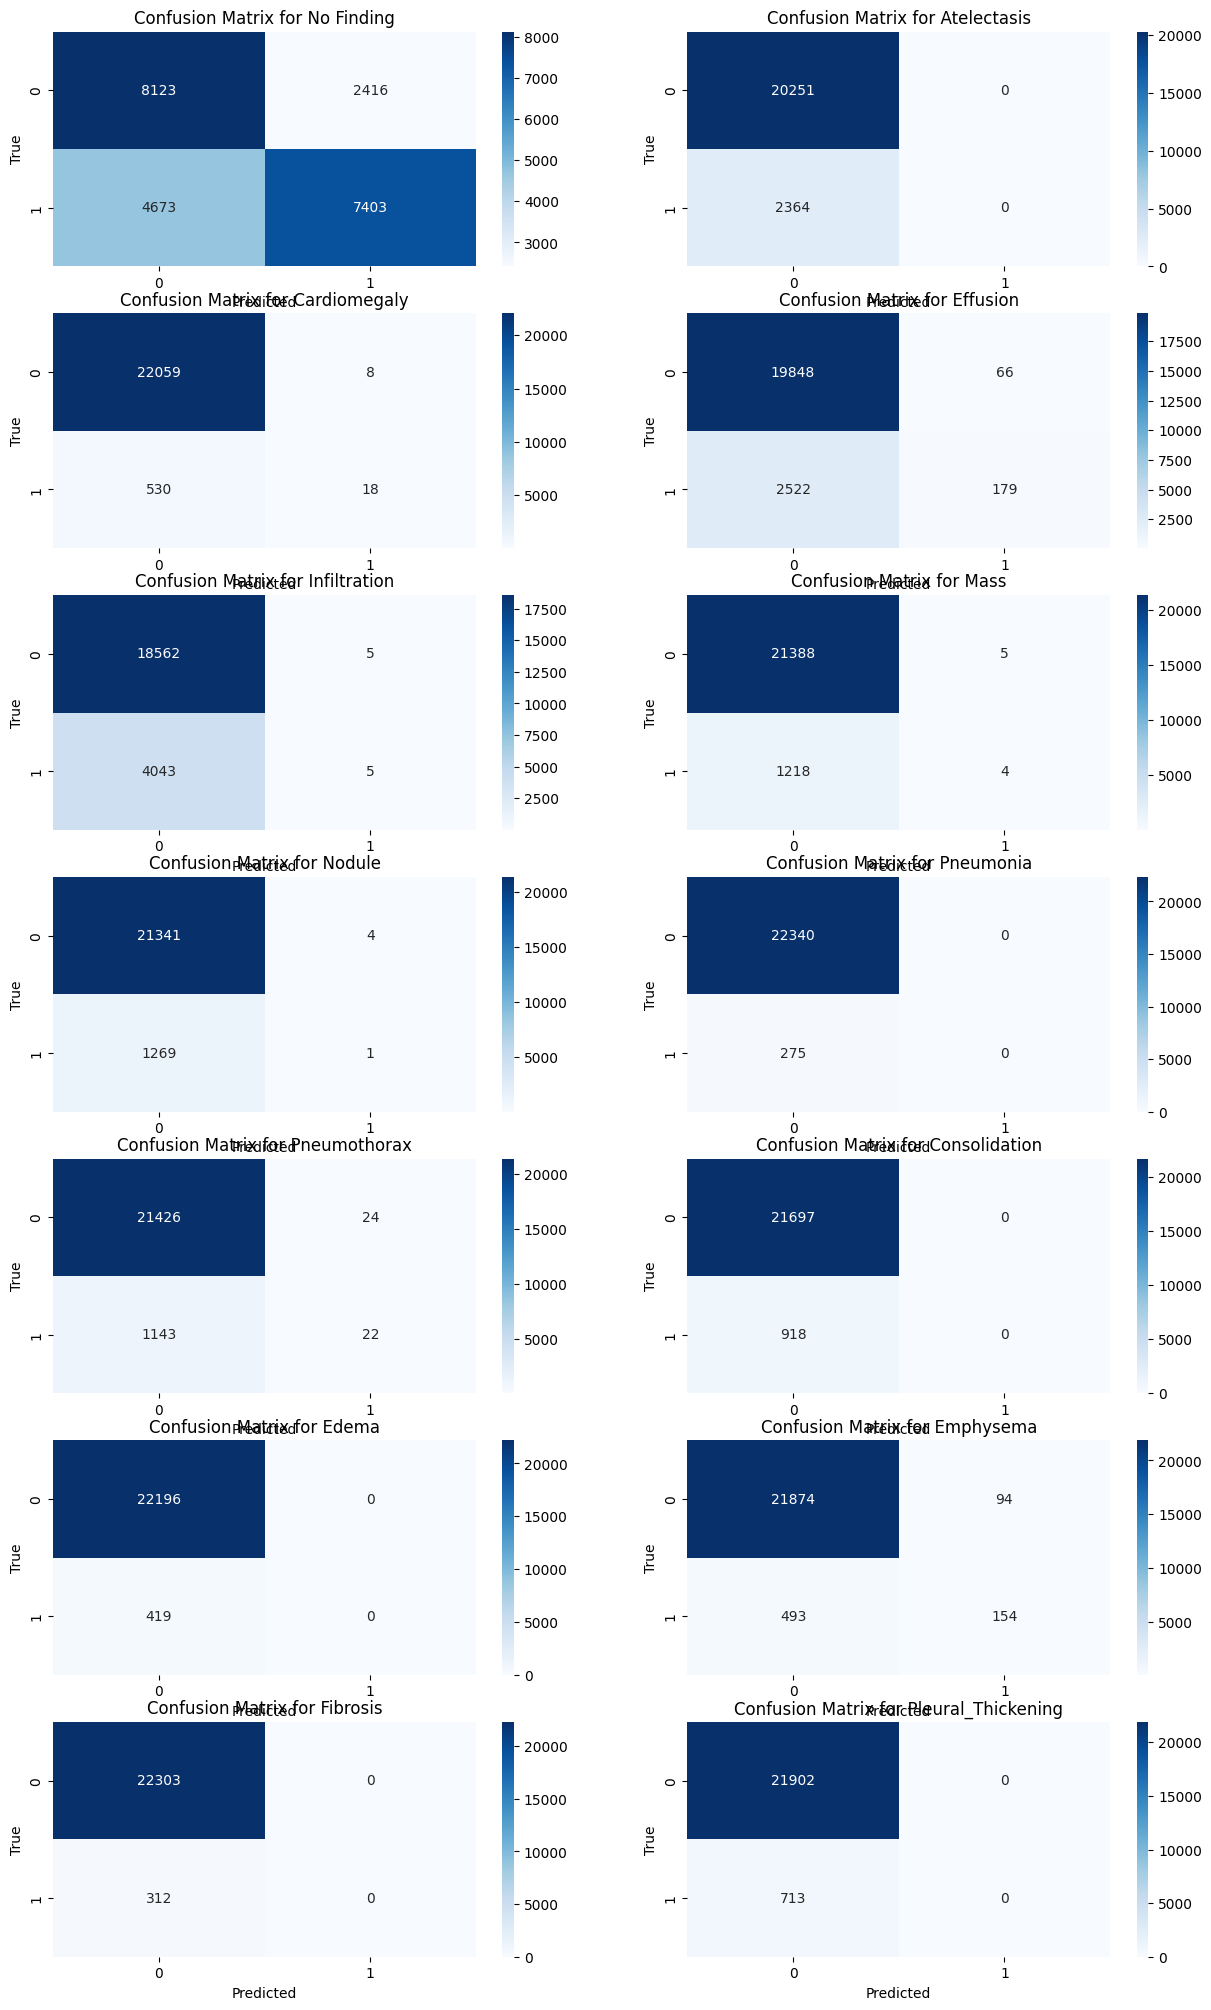

In [6]:
from sklearn.metrics import multilabel_confusion_matrix

mcm = multilabel_confusion_matrix(all_labels, all_preds_binary)

plt.figure(figsize=(15, 25))
for i, class_name in enumerate(classes):
    cm = mcm[i]
    plt.subplot(7, 2, i+1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {class_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt

num_samples = 5
indices = random.sample(range(len(val_dataset)), num_samples)

inv_normalize = transforms.Normalize(
    mean=[-m/s for m, s in zip([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])],
    std=[1/s for s in [0.229, 0.224, 0.225]]
)

for idx in indices:
    image, label = val_dataset[idx]
    
    inv_img = inv_normalize(image).permute(1,2,0).numpy().clip(0,1)
    
    plt.figure(figsize=(5,5))
    plt.imshow(inv_img)
    plt.axis('off')
    
    # Get true labels
    true_labels = [classes[i] for i, val in enumerate(label) if val == 1]
    
    image_tensor = image.unsqueeze(0).to(device)
    with torch.no_grad():
        pred = model(image_tensor).cpu().numpy().squeeze()
    pred_labels = [classes[i] for i, val in enumerate(pred > 0.7) if val]
    
    plt.title(f"True: {', '.join(true_labels)}\nPred: {', '.join(pred_labels)}")
    plt.show()
